<b>Data mining Project - 2020/21</b><br/>
<span>
<b>Authors:</b> <a href="http://------">Diletta Goglia</a> and <a href="http://------">Marco Petix</a><br/>
<b>Python version:</b>  3.x<br/>
<b>Last update:</b> 26/10/2020
</span>

# Task 1 : Data Understanding and Preparation


# Task 1.1 : Data Understanding

## Introduction and dataset description

This notebook contains an explorative analysis of the **"customer_supermarket"** dataset describing purchases and shopping sessions.

The data is organised in a form of an array, where the dataset attributes (aka features) are organised in columns, and the shoppig sessions (aka instances) in rows. The dataset consists of several data categories describing the purchases performed by the customers (i.e. the id of the virtual basket associated with the purchase, the id and description of the product purchased, the time and date when the transaction took place, etc.). 

The dataset includes 471910 data observations.


**Importing libraries and loading dataset**

In [294]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

**Loading the dataset**

Read the .csv file containing the data. The first line contains the list of attributes. The data is assigned to a Pandas dataframe.

In [295]:
df = pd.read_csv('dataset/customer_supermarket.csv', sep='\t', index_col=0)

## Data semantics

The function **head()** provides some of the first records of the dataframe.
We use it in order to assess the correct loading of the dataset and to provide a example of the records contained within it.

In [296]:
print(df.head()) #print the first records of a df

  BasketID      BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365  01/12/10 08:26  2,55    17850.00  United Kingdom  85123A   
1   536365  01/12/10 08:26  3,39    17850.00  United Kingdom   71053   
2   536365  01/12/10 08:26  2,75    17850.00  United Kingdom  84406B   
3   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029G   
4   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  


### Types of Attributes and basic checks

The Pandas function **info()** is used in order to obtain preliminary information on the dataset.
It highlights the data type and counts the number of not-null values for each column of the dataset.

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


The aforementioned function, other than identifying 471910 as the number of records contained within the dataframe, highlights:
1. the inability of Pandas to recognize the values of *BasketDate* as datetime;
2. the misinterpretation of the values of the attribute *Sale*, being represented as objects and not real numbers, due to the use of the **comma as delimiter for decimal values**;
3. the presence of **missing values** within the attributes *CustomerID* and *ProdDescr*;
4. the presence of **non numerical values** within the attributes *BasketID* and *ProductID*, despite an expectation at a first intuitive level could suggest them to be integer.

Moreover, we notice that we only have attributes of the type **categorical**, **numeric** and **ratio-scaled** (there are not 'binary' and 'ordinal' types of data).

Here we present a classification of these attributes by type:

- Categorical Attributes:<br>
    - *BasketID*
    - *CustomerID*
    - *CustomerCountry*
    - *ProdID*
    - *ProdDescr*


- Numerical Attributes:<br>
    - *BasketDate*
    - *Sale*
    - *Qta*

### Type conversion

Now we address the first two issues referred above, we want Pandas to:
+ recognize the values from *BasketDate* as datetime and, 
+ recognize the values from *Sale* as floats.

Both of them are fixable by tinkering with the arguments **parse_dates** and **decimal** from the pandas function **read_csv()** as in :

In [298]:
# df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0, decimal = ",",
#                 parse_dates=["BasketDate"])

But for the sake of this notebook we will make use of the casting functions provided by Pandas.

***BasketDate***<br>
We use the pandas function **to_datetime()** in order to correctly format the values from *BasketDate*.

In [299]:
df['BasketDate'] = pd.to_datetime(df['BasketDate']) # converting 'BasketDate' to datetime

***Sale***<br>
The presence of commas as decimal delimiters is common when working with European data.

We substitute the commas with dots in the *Sale* column and convert it from object to float type using Pandas **astype()** function.

In [300]:
df['Sale'] = df['Sale'].str.replace(',', '.') # replacing commas with dots
df['Sale'] = df['Sale'].astype(float) # converting 'Sale' to float type
df['Sale'].head()

0   2.55
1   3.39
2   2.75
3   3.39
4   3.39
Name: Sale, dtype: float64

**Extra: On *CustomerIDs*,floats, integers and objects**

Right now the value from the *CustomerID* attribute are represented as floats. However, as confermed by the code below, each value contained within said column is either a NaN value or a floating number with a decimal part equal to zero. 

In [301]:
df[df.CustomerID.notna()].CustomerID.apply(lambda x:x - int(x) == 0).all()

True

Moreover, given the index role of *CustomerID*, its representation as a numeric data is not useful for our analysis. The pandas **astype()** function is, therefore, used to cast the values from said attribute as objects. 

In [302]:
df['CustomerID'] = df['CustomerID'].astype(object) # converting 'CustomerID' to object type

We check again the data types after having fixed them:

In [303]:
df.dtypes # return the type of each attribute
          # provides list of attribute with the respective type

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

## Statistics and Data Distribution


### Statistics
The pandas function **describe()** is used to obtain basic statistical notions regarding the numerical attributes of the dataset.

In [304]:
pd.options.display.float_format = '{:.2f}'.format
df.describe() # this function provides a summary of statistical informations

,Sale,Qta
count,471910.00,471910.00
mean,4.03,10.72
std,83.77,231.36
min,-11062.06,-80995.00
25%,1.25,1.00
50%,2.08,4.00
75%,3.75,12.00
max,38970.00,80995.00


The data provided by the function highlight:
- both *Sale* and *Qta* as positively skewed.
- the presence of **negative values** within both columns, again, *Sale* and *Qta* .
- an high variance for both attributes, perhaps due to the presence of **outliers**.

#### Negative values in *Sale* and *Qta*

Trying to contextualize the presence of records containing such values within the dataset, we briefly check their value for the *ProdDescr* attribute.
A deeper analysis concerning the possibility of outliers does still take place in the section **Assessing and Improving Data Quality**. 

##### Sale

We compute a list of the records with negative values for *Sale*.

In [305]:
# Negative values in Sale
df[df.Sale < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


In [306]:
df[df.Sale < 0].ProdDescr

299983    Adjust bad debt
299984    Adjust bad debt
Name: ProdDescr, dtype: object

According to the description associated with both records (*ProdDescr* : "Adjust bad dept"), these transactions could be associated with some kind of refund operation.
    

Anyway, the statistical significance that these two isolated cases have with respect to the analysis of the dataset in question is minimal if compared to the remaining amount of data. <br>Considering these two records as **outliers**, could therefore **improve the total reliability of the remaining tests** conducted on the dataset.

As already mentioned, the further discussion about removing them continues in the section **Assessing and Improving Data Quality**.

##### Qta

We compute a list of the records with negative values for *Qta*.

In [307]:
# Negative values in Qta
df[df.Qta < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527.00,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311.00,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548.00,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [308]:
df[df.Qta < 0].ProdDescr

141                               Discount
154        SET OF 3 COLOURED  FLYING DUCKS
235         PLASTERS IN TIN CIRCUS PARADE 
236       PACK OF 12 PINK PAISLEY TISSUES 
237       PACK OF 12 BLUE PAISLEY TISSUES 
                        ...               
540449     ZINC T-LIGHT HOLDER STARS SMALL
541541                              Manual
541715          VICTORIAN SEWING BOX LARGE
541716    HANGING HEART JAR T-LIGHT HOLDER
541717       36 PENCILS TUBE RED RETROSPOT
Name: ProdDescr, Length: 9752, dtype: object

This time the records with a negative value for *Qta* are over 9000 and this amount does guarantee a stronger statistical relevance with respect to the analysis of the dataset.

The values of *ProdDescr* associated with these records, however, don't provide any contextualization for the values of *Qta*.
The best hypothesis remains that one of transactions during which the company acquired some asset from the customers instead of selling it to them.

#### Other interesting considerations: high and symmetrical values in Qta

The *min* and *max* values displayed by the **describe()** function for the *Qta* highlight and interesting dynamic concerning couples of records with high and opposite values for *Qta*. 
The list below contains two of such couples.  

In [309]:
df[df.Qta.apply(abs) > 10000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
61619,541431,2011-01-18 10:01:00,1.04,12346.00,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
61624,C541433,2011-01-18 10:17:00,1.04,12346.00,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
502122,578841,2011-11-25 15:57:00,0.00,13256.00,United Kingdom,84826,ASSTD DESIGN 3D PAPER STICKERS,12540
540421,581483,2011-09-12 09:15:00,2.08,16446.00,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
540422,C581484,2011-09-12 09:27:00,2.08,16446.00,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995


Such records probably refer to transactions cancelled shortly after the initial purchase.

## Assessing and improving Data Quality

### Handling duplicates

The pandas function **duplicated()** returns a list of boolean values where each *True* corresponds to the duplicate of a row within the dataframe. 

In [310]:
df.duplicated().any()

True

In [311]:
df.duplicated().value_counts()

False    466678
True       5232
dtype: int64

Having confirmed the presence of 5232 duplicated rows within the dataframe, we print some of them as samples:

In [312]:
duplicates = df[df.duplicated()]
duplicates.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
517,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1
527,536409,2010-01-12 11:45:00,2.10,17908.00,United Kingdom,22866,HAND WARMER SCOTTY DOG DESIGN,1
537,536409,2010-01-12 11:45:00,2.95,17908.00,United Kingdom,22900,SET 2 TEA TOWELS I LOVE LONDON,1
539,536409,2010-01-12 11:45:00,4.95,17908.00,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,1
555,536412,2010-01-12 11:49:00,2.95,17920.00,United Kingdom,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1


We print a couple of records consisting in an "original" row and its duplicate.

In [313]:
df[(df.ProdDescr == "UNION JACK FLAG LUGGAGE TAG") & (df.CustomerID == 17908)]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
494,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1
517,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1


Assuming, for personal interpretation, the presence of duplicate records as the result of errors during data entry, and not as the intentional addition of multiple transactions, they are deleted from the dataset.

In [314]:
df.drop_duplicates(inplace=True)
df.duplicated().any()

False

### Handling missing values
#### Missing values detection
We confirm what was established by the **info()** function regarding missing values within the dataset by making use of the pandas function **isnull()**.

In [315]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

As mentioned above, the columns *CustomerID* and *ProdDescr* present missing values.

Other missing values could also be contained within the columns of numerical attributes like *Qta* or *Sale* (i.e. represented by a 0),
therefore, specific code needs to be written in order to check for these cases.

#### Missing values in *Sale* and *Qta*
We search for values equal to zero within both of the attributes.

In [316]:
df[df.Qta == 0].Qta.count() #Zero values in Qta

0

In [317]:
df[df.Sale == 0].Sale.count() #Zero values in Sale

1278

The sales column has 1279 values equal to zero but, given the transactional
nature of the dataset under examination, we believe that the aforementioned
zero values do retain a useful significance for the purposes of our analysis.

Therefore, these attributes are not going to be involved in the process of replacing
missing values which is now focused only on the categorical attributes of the dataset.

#### Missing values in the other categorical attributes

***CustomerCountry***

We compute a list of all the different values associated with the *CustomerCountry* attribute.

In [318]:
df.CustomerCountry.value_counts()

United Kingdom          421106
Germany                   9480
France                    8509
EIRE                      7814
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1931
Portugal                  1486
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                337
USA                        291
Israel                     266
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  137
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

The list above presents an "**Unspecified**" value for *CustomerCountry* associated with 340 different records. 
Given the inherent ambiguity of the value we consider it a strong candidate for a replacement with values with a stronger statistical significance.

Before committing to this decision, however, we check for the values within the *CustomerID* column of the records that present an "Unspecified" *CustomerCountry*.
Other transactions of the same customers, represented here by other records with the same value for *CustomerID*, may display a different value of *CustomerCountry* suitable to replace the others.

We compute a list of all the values for *CustomerID* associated with records with an "Unspecified" *CustomerCountry*.

In [319]:
unspecified_ids = df[df.CustomerCountry == 'Unspecified'].CustomerID.value_counts()
unspecified_ids.keys()

Float64Index([12743.0, 16320.0, 14265.0, 12363.0], dtype='float64')

We now check for every value of *CustomerCountry* associated with said values of *CustomerID*.

In [320]:
df.loc[df.CustomerID.isin(unspecified_ids.keys())].CustomerCountry.value_counts()

Unspecified    241
Name: CustomerCountry, dtype: int64

Only 241 records result associated with the aforementioned values of *CustomerID*. 

In order to ascertain the state of the 96 unaccounted rows, we now count the number of records with an "Unspecified" *CustomerCountry* and a NaN *CustomerID*.

In [321]:
nan_count = df[df.CustomerCountry == "Unspecified"].isna().CustomerID.value_counts()
nan_count

False    241
True      96
Name: CustomerID, dtype: int64

We have confermed that none of the records we have referred to are associated with a value for *CustomerCountry* other than "Unspecified".
This set of records therefore acts as an autonomous group.

While it is still possible to replace the values in question with the most frequent value of this attribute (in this case United Kingdom), we believe it is more interesting to wait for the results of the clustering process in view of a hypothetical grouping with records associated with another particular country.

***ProdID***

We compute a list of all the different values associated with the *ProdID* attribute.

In [322]:
df.ProdID.value_counts()

85123A      2179
22423       2031
85099B      1914
47566       1562
20725       1479
            ... 
20954          1
DCGS0004       1
m              1
84206B         1
84247C         1
Name: ProdID, Length: 3953, dtype: int64

The aforementioned attribute presents 3953 unique values and this wide array of variety stands in the way of a deeper analysis of each single value.

#### Replacing missing values

##### Replacing the missing values from *CustomerID*

The CustomerID column presents 65073 missing values.

In [323]:
df.CustomerID.isnull().sum()

65073

In order to effectively replace said values we select the most frequent IDs in a given *CustomerCountry* (the mode over a subset of the *CustomerID* column) as a substitute for the missing values associated with it.

These are the most frequent CustomerID for each *CustomerCountry*:

In [324]:
country_mode = df.groupby(['CustomerCountry']).agg(lambda x:x.mode()).CustomerID
print(country_mode)

CustomerCountry
Australia              12415.00
Austria                12360.00
Bahrain                12355.00
Belgium                12362.00
Brazil                 12769.00
Canada                 17444.00
Channel Islands        14936.00
Cyprus                 12359.00
Czech Republic         12781.00
Denmark                12406.00
EIRE                   14911.00
European Community     15108.00
Finland                12428.00
France                 12681.00
Germany                12471.00
Greece                 12717.00
Hong Kong                    []
Iceland                12347.00
Israel                 12688.00
Italy                  12584.00
Japan                  12753.00
Lebanon                12764.00
Lithuania              15332.00
Malta                  17828.00
Netherlands            14646.00
Norway                 12433.00
Poland                 12779.00
Portugal               12757.00
RSA                    12446.00
Saudi Arabia           12565.00
Singapore              1

We now check for every value of *CustomerCountry* associated with said values of *CustomerID*.

No CustomerID is associated with any of the records with *CustomerCountry* equals to "Hong Kong". For the sake of replacing these empty values we craft a custom CustomerID and add it to the aforementioned list.

In [325]:
df[df.CustomerID == "18288.0"].CustomerID.count() #We check to see if the custom ID is already present within the dataset 

0

In [326]:
country_mode["Hong Kong"] = "18288.0"

Now we substitute each missing value with the corresponding element from the list.

In [327]:
#We replace the missing values from CustomerID with the elements from country_mode
df['CustomerID'] = df.apply(
    lambda row: country_mode[row['CustomerCountry']] if pd.isnull(row['CustomerID']) else row['CustomerID'],
    axis=1
)

After the process the number of missing values is down to zero.

In [328]:
df.CustomerID.isnull().sum()

0

### Outliers detection

We have already mentioned how both the *Sale* and *Qta* attributes contain very high values that could be easily classified as outliers, here we provide a deeper analysis of said phenomenon.

These are the boxplots for the two attributes computed by the pandas function **boxplot()**:

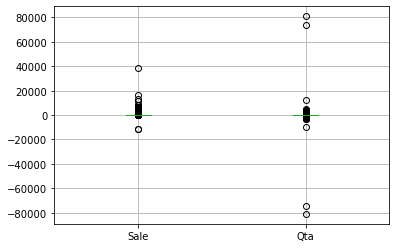

In [329]:
df.boxplot()

Indeed both plots seem to be deeply affected by outliers. 
We proceed by computing the **interquantile range** (**IQR**) and by limiting the plot to the points within it.

We start by defining a function for computing the IQR:

In [330]:
def iqr_values(s): 
    q1 = s.quantile(q = 0.25)
    q3 = s.quantile(q = 0.75)
    iqr = q3 - q1
    iqr_left = q1 - 1.5*iqr
    iqr_right = q3 + 1.5*iqr
    return iqr_left, iqr_right

Now we apply said function to *Sale* and plot the new boxplot. 

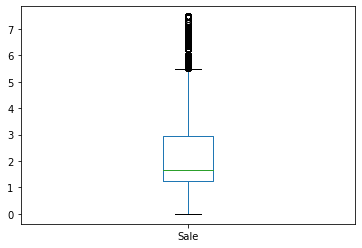

In [331]:
left_sale, right_sale = iqr_values(df.Sale)
df[(df.Sale > left_sale) & (df.Sale < right_sale)].Sale.plot.box()

We do the same the *Qta* attribute.

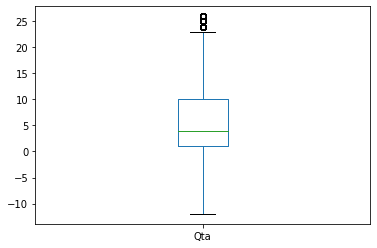

In [332]:
left_qta, right_qta = iqr_values(df.Qta)
df[(df.Qta > left_qta) & (df.Qta < right_qta)].Qta.plot.box()

We select the records containing outliers for the *Sale* and *Qta* attributes.

In [333]:
df_outliers = df[(df.Sale < left_sale) | (df.Sale > right_sale) | (df.Qta < left_qta) | (df.Qta > right_qta)]
df_outliers

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
5,536365,2010-01-12 08:26:00,7.65,17850.00,United Kingdom,22752,SET 7 BABUSHKA NESTING BOXES,2
13,536367,2010-01-12 08:34:00,1.69,13047.00,United Kingdom,84879,ASSORTED COLOUR BIRD ORNAMENT,32
20,536367,2010-01-12 08:34:00,9.95,13047.00,United Kingdom,22622,BOX OF VINTAGE ALPHABET BLOCKS,2
23,536367,2010-01-12 08:34:00,7.95,13047.00,United Kingdom,21777,RECIPE BOX WITH METAL HEART,4
24,536367,2010-01-12 08:34:00,7.95,13047.00,United Kingdom,48187,DOORMAT NEW ENGLAND,4
...,...,...,...,...,...,...,...,...
541866,581583,2011-09-12 12:23:00,1.85,13777.00,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36
541867,581584,2011-09-12 12:25:00,0.72,13777.00,United Kingdom,20832,RED FLOCK LOVE HEART PHOTO FRAME,72
541868,581584,2011-09-12 12:25:00,1.85,13777.00,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48
541892,581586,2011-09-12 12:49:00,8.95,13113.00,United Kingdom,21217,RED RETROSPOT ROUND CAKE TINS,24


We delete the records containing outliers from the dataframe.

In [334]:
df.drop(df_outliers.index, inplace=True)

## Data Normalization
We use the MinMaxScaler class available in the Scikit-learn library. First, we create a scaler object. Then, we fit the scaler parameters, meaning we calculate the minimum and maximum value for each feature. Finally, we transform the data using those parameters.

In [335]:
from sklearn.preprocessing import MinMaxScaler

sale = pd.DataFrame(df.Sale)

# create a scaler object
scaler = MinMaxScaler()

# fit and transform the data
sale_norm = pd.DataFrame(scaler.fit_transform(sale))

# set the index
sale_norm.index = df.index

sale_norm

,0
0,0.34
1,0.45
2,0.37
3,0.45
4,0.45
...,...
541904,0.11
541905,0.28
541906,0.55
541907,0.55


In [336]:
# new normalized dataframe
df_norm = df.copy()
df_norm.Sale = sale_norm
df_norm

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,0.34,17850.00,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,0.45,17850.00,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,0.37,17850.00,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,0.45,17850.00,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,0.45,17850.00,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541904,581587,2011-09-12 12:50:00,0.11,12680.00,France,22613,PACK OF 20 SPACEBOY NAPKINS,12
541905,581587,2011-09-12 12:50:00,0.28,12680.00,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,0.55,12680.00,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,0.55,12680.00,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4


## Correlation coefficient and scatter plots

We use the pandas **corr()** function to compute the **pearson correlation coefficient** for the numerical attributes of the dataset: *Sale* and *Qta*.

In [337]:
df_norm.corr()

,Sale,Qta
Sale,1.00,-0.34
Qta,-0.34,1.00


Despite counting on results similar to those just computed, we compare the pearson correlation coefficient, calculated by default by the **corr()** function, with the **Kendall** and **Spearman** correlations.

In [338]:
df_norm.corr(method='kendall')

,Sale,Qta
Sale,1.00,-0.25
Qta,-0.25,1.00


In [339]:
df_norm.corr(method='spearman')

,Sale,Qta
Sale,1.00,-0.33
Qta,-0.33,1.00


Ultimately, according to the values above, the two attributes seems to be slightly correlated. 
<br>Moreover, the negative sign of the coefficient highlights how the attributes tend to move in opposite direction.

### Scatterplots

We proceed by visualizing the correlation through the use of scatterplots. 

Text(0.5, 1.0, 'Correlation between Sale and Qta during the day')

C:\Users\Diletta\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


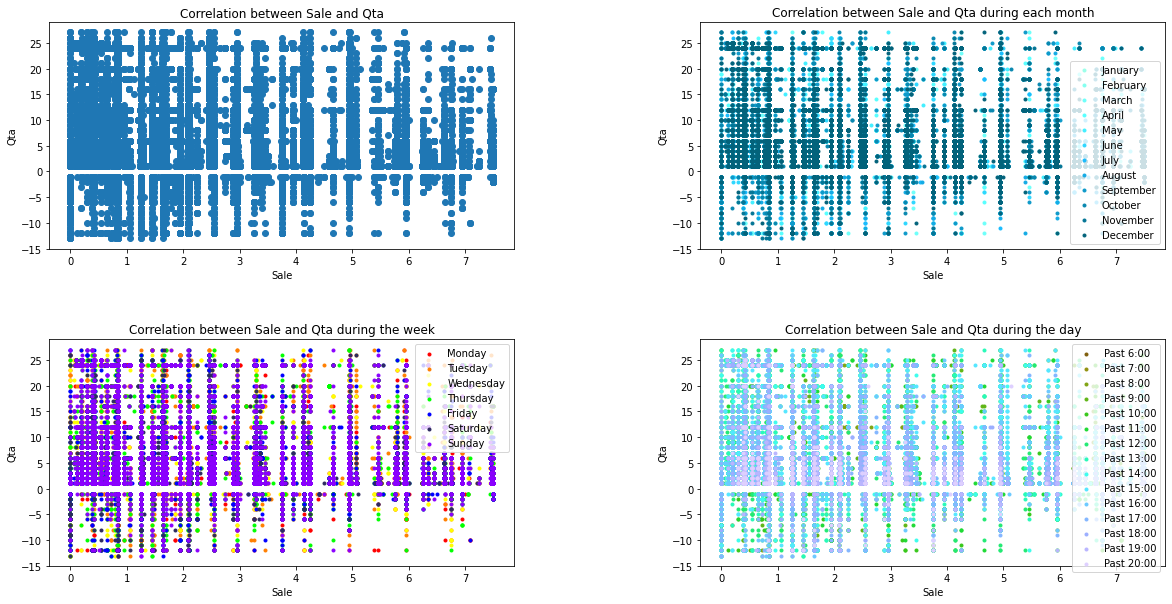

In [340]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 10))
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

colors_days = ["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#2E2B5F", "#8B00FF"]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
colors_months = ["#004F61", "#03637B", "#057696", "#0988B0", "#0E9ACA", "#14ABE5", "#1ABCFE", "#2ED7FF", "#43EFFF", "#58FFFF", "#6EFFFA", "#85FFF0", "#9CFFEA"]
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
colors_hours = ["#805F0D", "#929210", "#81A413", "#60B617", "#38C81B", "#1FDA35", "#23EA74", "#28FAB9", "#3EFDED", "#55E7FF", "#6CCAFF", "#84B7FF", "#9CAFFF", "#BAB6FF", "#DED0FF"]
hours = ["Past 6:00", "Past 7:00", "Past 8:00", "Past 9:00", "Past 10:00", "Past 11:00", "Past 12:00", "Past 13:00", "Past 14:00", "Past 15:00", "Past 16:00", "Past 17:00", "Past 18:00", "Past 19:00", "Past 20:00"]

# Scatterplot between Sale and Qta
plt.subplot2grid(fig_dims, (0, 0))
plt.scatter(df['Sale'], df['Qta'])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.title('Correlation between Sale and Qta')

# Scatterplot between Sale and Qta with the month of the transaction highlighted by color
plt.subplot2grid(fig_dims, (0, 1))
for i in range(12):
    plt.scatter(df[df['BasketDate'].dt.month == i - 1]['Sale'],
            df[df['BasketDate'].dt.month == i - 1]['Qta'], color=colors_months[12 - i ], marker='.', label=months[i])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.legend()
plt.title('Correlation between Sale and Qta during each month')

# Scatterplot between Sale and Qta with the day of the week of the transaction highlighted by color
plt.subplot2grid(fig_dims, (1, 0))
for i in range(7):
    plt.scatter(df[df['BasketDate'].dt.weekday == i]['Sale'],
            df[df['BasketDate'].dt.weekday == i]['Qta'], color=colors_days[i], marker='.', label=days[i])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.legend()
plt.title('Correlation between Sale and Qta during the week')


# Scatterplot between Sale and Qta with the hour of the transaction highlighted by color
plt.subplot2grid(fig_dims, (1, 1))
for i in range(6, 21):
    plt.scatter(df[df['BasketDate'].dt.hour == i]['Sale'],
            df[df['BasketDate'].dt.hour == i]['Qta'], color=colors_hours[i - 6], marker='.', label=hours[i - 6])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.legend()
plt.title('Correlation between Sale and Qta during the day')

### Distributions

#### BasketDate

Text(0, 0.5, 'Number of records')

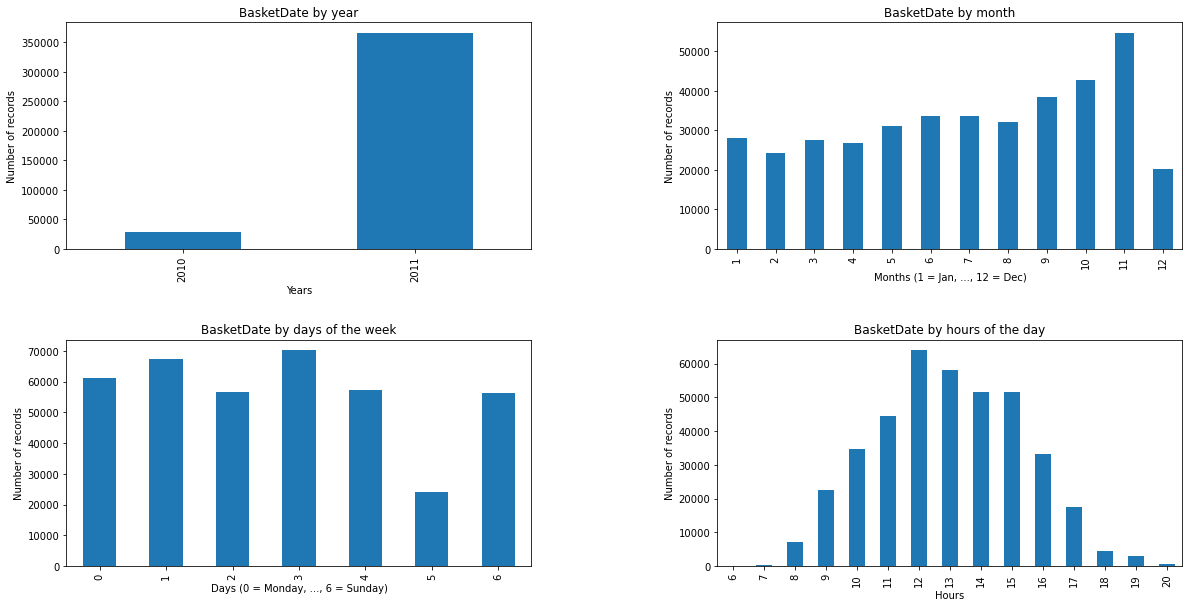

In [341]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 10))
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)



# Plot BasketDate by Years
plt.subplot2grid(fig_dims, (0, 0))
df['BasketDate'].groupby(df.BasketDate.dt.year).agg('count').plot(kind="bar")
plt.title("BasketDate by year")
plt.xlabel("Years")
plt.ylabel("Number of records")



# Plot BasketDate by Months
plt.subplot2grid(fig_dims, (0, 1))
df['BasketDate'].groupby(df.BasketDate.dt.month).agg('count').plot(kind="bar")
plt.title("BasketDate by month")
plt.xlabel("Months (1 = Jan, ..., 12 = Dec)")
plt.ylabel("Number of records")



# Plot BasketDate by Day of the Week
plt.subplot2grid(fig_dims, (1, 0))
df['BasketDate'].groupby(df.BasketDate.dt.weekday).agg('count').plot(kind="bar")
plt.title("BasketDate by days of the week")
plt.xlabel("Days (0 = Monday, ..., 6 = Sunday)")
plt.ylabel("Number of records")



# Plot BasketDate by Hour of the day
plt.subplot2grid(fig_dims, (1, 1))
df['BasketDate'].groupby(df.BasketDate.dt.hour).agg('count').plot(kind="bar")
plt.title("BasketDate by hours of the day")
plt.xlabel("Hours")
plt.ylabel("Number of records")

#### Sale

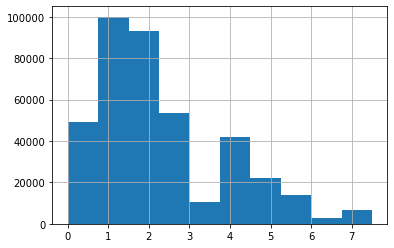

In [342]:
df.Sale.hist()

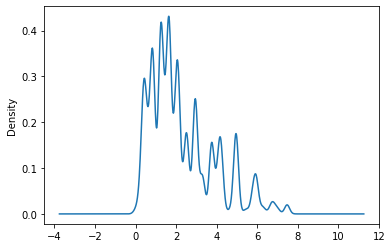

In [343]:
df.Sale.plot(kind='kde')

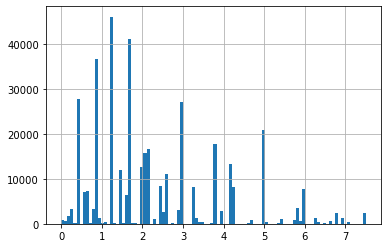

In [344]:
n_bin = int(math.sqrt(df.count()[0]))
df.Sale.hist(bins=100)

The graphs above display that few records present extremely high values for the *Sale* attributes while most of the other values are grouped together below the mean.<br>
Said behaviour classifies the distribution of *Sale* as **positively skewed**.


!!! <b>MAKE SOME KIND OF PLOT THAT MAKES SENSE</b> !!!

#### CustomerCountry

In [345]:
df.CustomerCountry.value_counts().count()

38

The records contained within the dataset present 38 possible values for the attribute *CustomerCountry*.

In [346]:
df.CustomerCountry.value_counts()

United Kingdom          358889
Germany                   7796
France                    7007
EIRE                      5867
Spain                     2060
Belgium                   1691
Switzerland               1511
Portugal                  1278
Norway                     784
Italy                      635
Netherlands                618
Australia                  573
Channel Islands            552
Finland                    522
Cyprus                     478
Austria                    345
Unspecified                303
Denmark                    301
Poland                     262
Sweden                     255
USA                        239
Israel                     208
Iceland                    166
Singapore                  151
Japan                      139
Canada                     126
Greece                     125
Malta                      102
Hong Kong                   92
United Arab Emirates        58
European Community          48
RSA                         46
Lebanon 

Among said values, "**United Kingdom**", being present within the 90% of the records in the dataset is the most frequent one.

In [347]:
uk_percentage = df[df.CustomerCountry == "United Kingdom"].count()[0] # number of records with CustomerCountry equals to "United Kingdom"
tot_rows = df.count()[0] # number of rows within the dataframe
uk_percentage = (uk_percentage / tot_rows)*100
print(uk_percentage)

91.23817223162851


Also, 340 different records present the value "**Unspecified**" for the attribute in question. (See **Missing values detection**) 

Text(0, 0.5, 'Number of records')

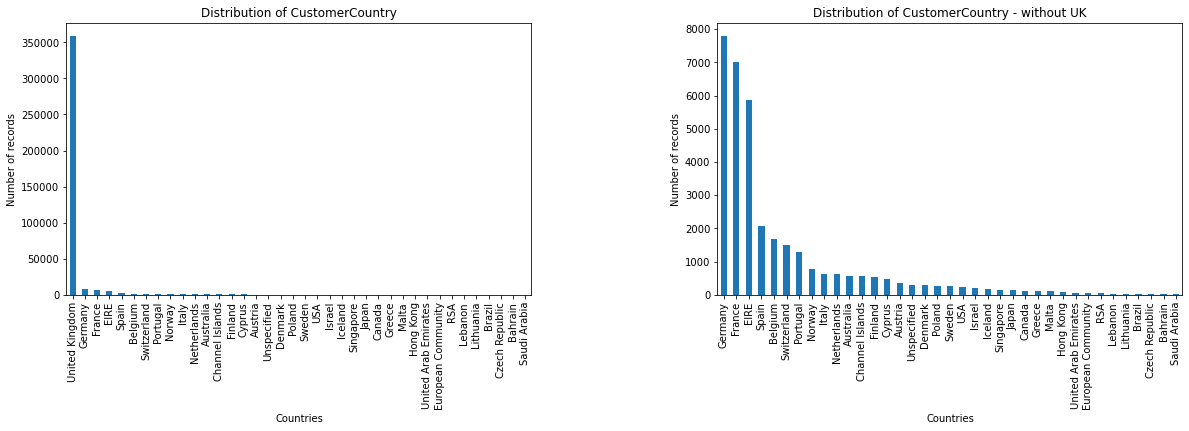

In [348]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 5))
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot Distribution of CustomerCountry
plt.subplot2grid(fig_dims, (0, 0))
df.CustomerCountry.value_counts().plot(kind='bar')
plt.title("Distribution of CustomerCountry")
plt.xlabel("Countries")
plt.ylabel("Number of records")

# Plot Distribution of CustomerCountry - without UK
plt.subplot2grid(fig_dims, (0, 1))
df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.value_counts().plot(kind='bar')
plt.title("Distribution of CustomerCountry - without UK")
plt.xlabel("Countries")
plt.ylabel("Number of records")


#### Qta

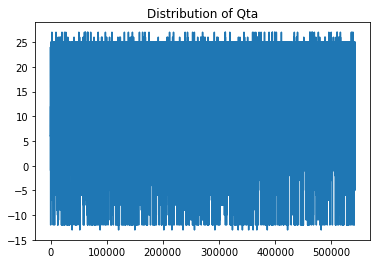

In [349]:
df.Qta.plot(title="Distribution of Qta")

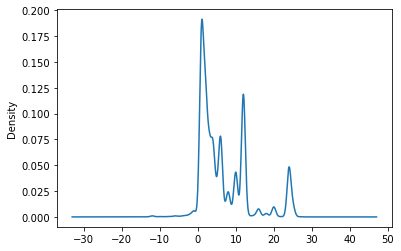

In [350]:
df.Qta.plot(kind='kde')

627


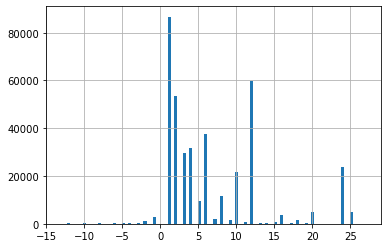

In [351]:
n_bin = int(math.sqrt(df.count()[0]))
print(n_bin)
df.Qta.hist(bins=100)

As for *Sale*, the values of *Qta* display a **positively skewed** behaviour. 
<br>Also, the graphs displays interesting couples of high symmetrical values. See **Outliers detection**.

# Data Visualization (plots)

   ### (Grafici non relativi a periodi di tempo)
   

#### Shopping sessions

How many shopping sessions for each country

In [352]:
print("Country \t Number of sessions")
df['BasketID'].groupby(df['CustomerCountry']).count().sort_values()

Country 	 Number of sessions


CustomerCountry
Saudi Arabia                10
Bahrain                     11
Czech Republic              19
Brazil                      25
Lithuania                   29
Lebanon                     33
RSA                         46
European Community          48
United Arab Emirates        58
Hong Kong                   92
Malta                      102
Greece                     125
Canada                     126
Japan                      139
Singapore                  151
Iceland                    166
Israel                     208
USA                        239
Sweden                     255
Poland                     262
Denmark                    301
Unspecified                303
Austria                    345
Cyprus                     478
Finland                    522
Channel Islands            552
Australia                  573
Netherlands                618
Italy                      635
Norway                     784
Portugal                  1278
Switzerland            

A total of 138 shopping sessions have been done in Hong Kong, but no customer IDs result for them.
Zero customers have been identified in Hong Kong, even if they have done a total of 138 sessions.

This problem is fixed in section ***Data Cleaning & Transformation***.

#### Products

Which are the most bought products

In [353]:
print("Product \t Quantity")
df['Qta'].groupby(df['ProdDescr']).sum().sort_values()
# stamparne di più

Product 	 Quantity


ProdDescr
damaged                                 -41
ebay                                    -30
damages                                 -21
POSTAGE                                 -20
crushed                                 -17
                                      ...  
LUNCH BAG RED RETROSPOT               10145
WHITE HANGING HEART T-LIGHT HOLDER    11164
JUMBO BAG RED RETROSPOT               13011
ASSORTED COLOUR BIRD ORNAMENT         14087
PACK OF 72 RETROSPOT CAKE CASES       15624
Name: Qta, Length: 3740, dtype: int64

   ### Periods plots


Before building plots for periods, we duplicate the dataframe and set the date as index for it. In this way we have this *ad hoc* dataframe for building plots, and we use it just for this purpose.

In [354]:
df2 = df.copy()
df2.index = pd.to_datetime(df['BasketDate'], format='%d/%m/%y %H:%M')
df2.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
BasketDate,,,,,,,,
2010-01-12 08:26:00,536365,2010-01-12 08:26:00,2.55,17850.00,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
2010-01-12 08:26:00,536365,2010-01-12 08:26:00,3.39,17850.00,United Kingdom,71053,WHITE METAL LANTERN,6
2010-01-12 08:26:00,536365,2010-01-12 08:26:00,2.75,17850.00,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
2010-01-12 08:26:00,536365,2010-01-12 08:26:00,3.39,17850.00,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
2010-01-12 08:26:00,536365,2010-01-12 08:26:00,3.39,17850.00,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


#### *Sale* plots
**Monthly**

Text(0, 0.5, 'Mean value')

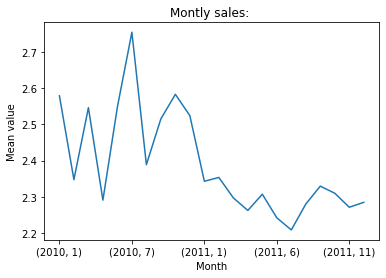

In [355]:
monthly_sales_mean = df2['Sale'].groupby([df2.index.year, df2.index.month]).mean().plot()
plt.title('Montly sales: ')
plt.xlabel('Month')
plt.ylabel('Mean value')

Text(0, 0.5, 'Sum')

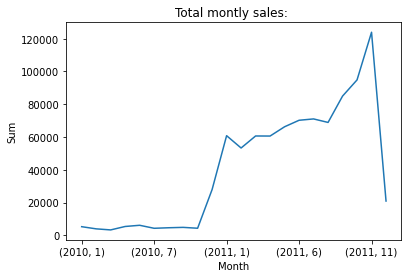

In [356]:
monthly_sales_total = df2['Sale'].groupby([df2.index.year, df2.index.month]).sum().plot()
plt.title('Total montly sales: ')
plt.xlabel('Month')
plt.ylabel('Sum')

**Weekly**

Text(0, 0.5, 'Mean')

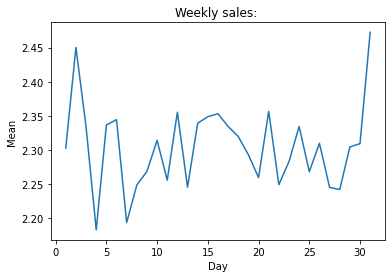

In [357]:
weekly_sales_mean = df2['Sale'].groupby(df2.index.day).mean().plot()
plt.title('Weekly sales: ')
plt.xlabel('Day')
plt.ylabel('Mean')

Text(0, 0.5, 'Sum')

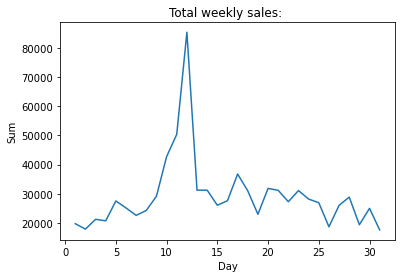

In [358]:
weekly_sales_total = df2['Sale'].groupby(df2.index.day).sum().plot()
plt.title('Total weekly sales: ')
plt.xlabel('Day')
plt.ylabel('Sum')

**Daily**

Text(0, 0.5, 'Mean value')

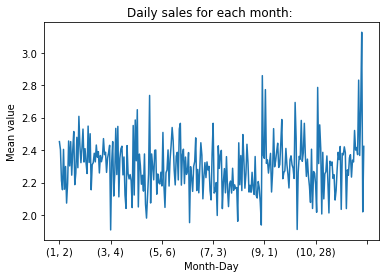

In [359]:
daily_sales_mean = df2['Sale'].groupby([df2.index.month, df2.index.day]).mean().plot()
plt.title('Daily sales for each month: ')
plt.xlabel('Month-Day')
plt.ylabel('Mean value')

Text(0, 0.5, 'Sum')

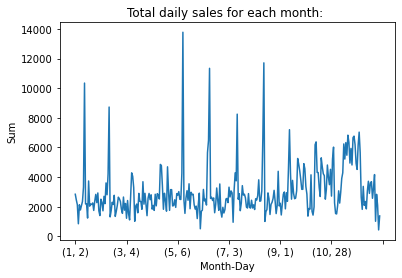

In [360]:
daily_sales_total = df2['Sale'].groupby([df2.index.month, df2.index.day]).sum().plot()
plt.title('Total daily sales for each month: ')
plt.xlabel('Month-Day')
plt.ylabel('Sum')

**Hourly**

Text(0, 0.5, 'Sum')

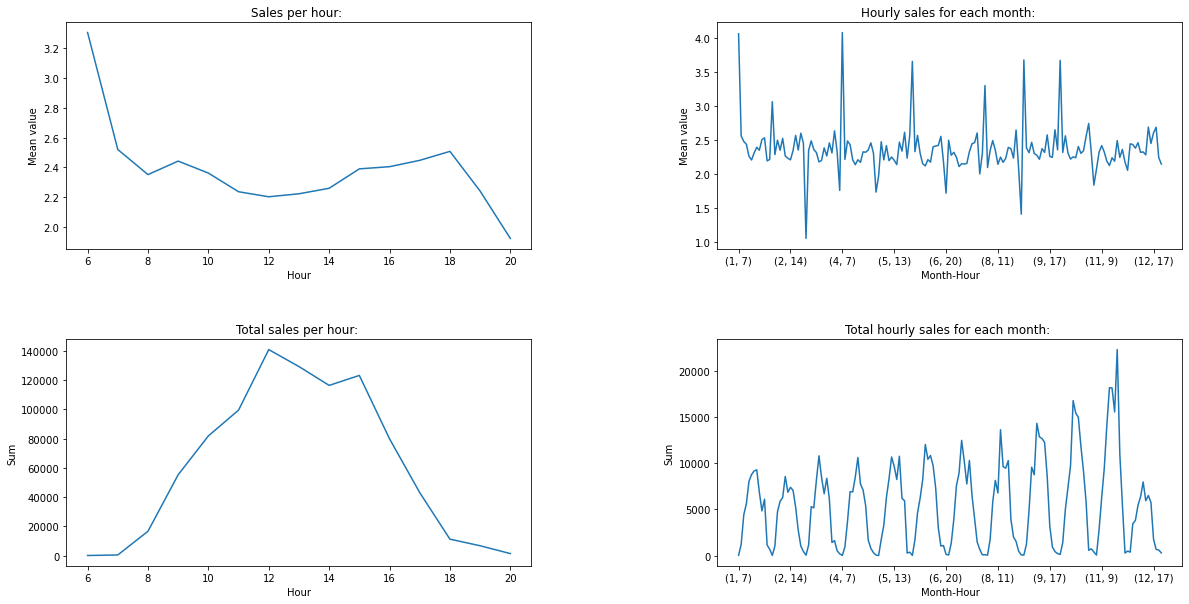

In [361]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 10))
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot mean sales per hour
plt.subplot2grid(fig_dims, (0, 0))
hourly_sales_mean = df2['Sale'].groupby(df2.index.hour).mean().plot()
plt.title('Sales per hour: ')
plt.xlabel('Hour')
plt.ylabel('Mean value')

# Plot total sales per hour
plt.subplot2grid(fig_dims, (1, 0))
hourly_sales_total = df2['Sale'].groupby(df2.index.hour).sum().plot()
plt.title('Total sales per hour: ')
plt.xlabel('Hour')
plt.ylabel('Sum')

# Plot mean sales per hour for each month
plt.subplot2grid(fig_dims, (0, 1))
hourly_sales_mean = df2['Sale'].groupby([df2.index.month, df2.index.hour]).mean().plot()
plt.title('Hourly sales for each month: ')
plt.xlabel('Month-Hour')
plt.ylabel('Mean value')

# Plot total sales per hour for each month
# evidente regolarità !!
plt.subplot2grid(fig_dims, (1, 1))
hourly_sales_total = df2['Sale'].groupby([df2.index.month, df2.index.hour]).sum().plot()
plt.title('Total hourly sales for each month: ')
plt.xlabel('Month-Hour')
plt.ylabel('Sum')


# New features 
## Preliminary check
Before extracting new features about customer purchasing behavior, we check some distributions about CustomerCountry attribute, to understand how their trend.

**Country plots (without UK)**

Motivare la scelta di togliere UK (per quegli attributi che non sono stati sottoposti a normalizzazione, quindi tutti tranne *Sale*)

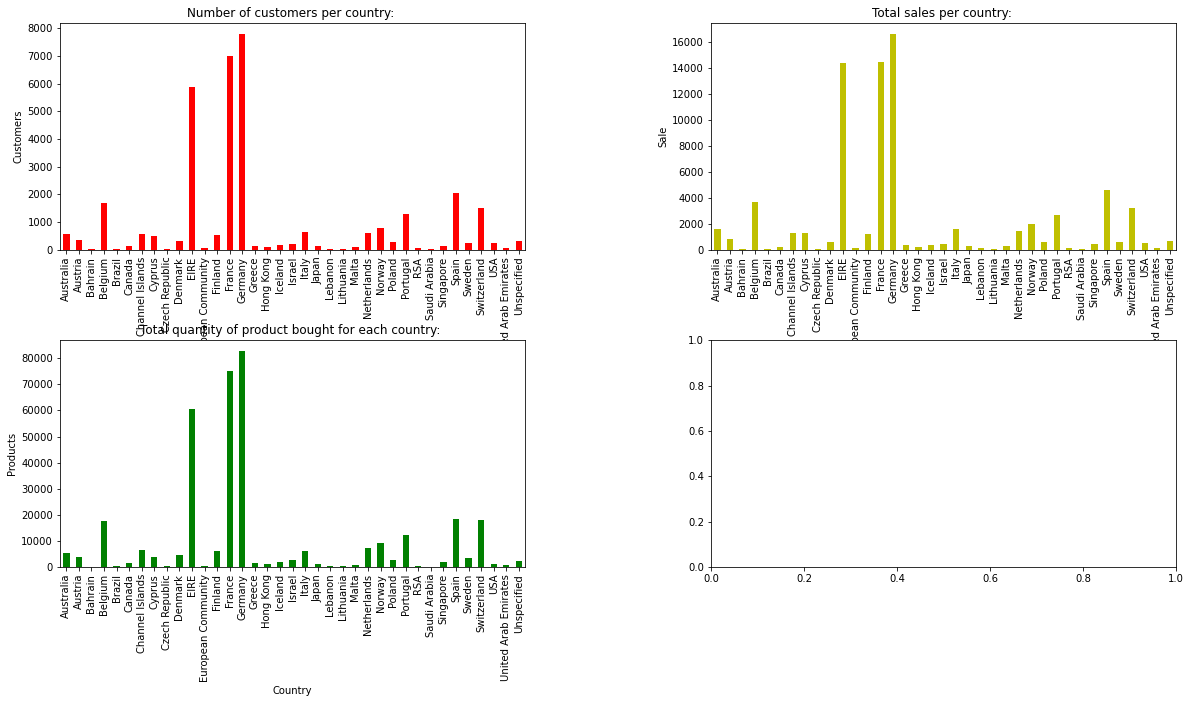

In [362]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 10))
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot total customers
plt.subplot2grid(fig_dims, (0, 0))
total_cust = df_norm['CustomerID'].groupby(df_norm['CustomerCountry']).count()
total_cust = total_cust.drop(['United Kingdom'])
total_cust.plot(kind='bar', color='r')
plt.title('Number of customers per country: ')
plt.xlabel('Country')
plt.ylabel('Customers')


# Plot total sale 
plt.subplot2grid(fig_dims, (0, 1))
total_sale = df['Sale'].groupby(df['CustomerCountry']).sum()
total_sale = total_sale.drop(['United Kingdom'])
total_sale.plot(kind='bar', color='y')
plt.title('Total sales per country: ')
plt.xlabel('Country')
plt.ylabel('Sale')

# Plot total products bought
plt.subplot2grid(fig_dims, (1, 0))
total_prod = df['Qta'].groupby(df['CustomerCountry']).sum()
total_prod = total_prod.drop(['United Kingdom'])
total_prod.plot(kind='bar', color='g')
plt.title('Total quantity of product bought for each country: ')
plt.xlabel('Country')
plt.ylabel('Products')

# Plot ...
plt.subplot2grid(fig_dims, (1, 1))




## Extraction
We now find and extract new features useful for describing the customer profile and his purchasing behavior.

For each customer, we extract the following indicators:
- ***I***: the total number of items purchased by a customer during the period of
observation.
- ***Iu***: the number of distinct items bought by a customer in the period of
observation.
- ***Imax***: the maximum number of items purchased by a customer during a
shopping session
- ***E***: the Shannon entropy on the purchasing behaviour of the customer



First of all, we extract the number of distinct customer:

In [363]:
print("There are", df.CustomerID.unique().size, "distinct customers. ") 

There are 4223 distinct customers. 


## "I" indicator


In [364]:
# total number of items purchased by a customer
customers = pd.DataFrame(df['Qta'].groupby(df['CustomerID']).sum())

# creating a new dataframe starting from "I" indicator
customers = customers.rename(columns={"Qta": "I"})

## "Iu" indicator

In [365]:
# number of distinct items bought by a customer
Iu = df['ProdID'].groupby(df['CustomerID']).unique().apply(len)

In [366]:
Iu = pd.DataFrame(Iu)

In [367]:
customers['Iu'] = Iu.ProdID

print('Customers dataset: \n')
customers

Customers dataset: 



,I,Iu
CustomerID,,
12347.0,1893,96
12348.0,140,6
12349.0,523,58
12350.0,196,16
12352.0,437,49
...,...,...
18281.0,52,5
18282.0,46,9
18283.0,1353,259


## "Imax" indicator

In [368]:
# maximum number of items purchased by a customer during a shopping session

Imax = df.groupby(by=[ 'CustomerID', 'BasketID']).Qta.sum().max(level='CustomerID')
Imax = pd.DataFrame(Imax)
customers['Imax'] = Imax.Qta
customers

,I,Iu,Imax
CustomerID,,,
12347.0,1893,96,548
12348.0,140,6,96
12349.0,523,58,523
12350.0,196,16,196
12352.0,437,49,119
...,...,...,...
18281.0,52,5,52
18282.0,46,9,26
18283.0,1353,259,241


## "E" indicator

The value of entropy is between 0 and log(n).
NB. *n* in this case is the number of distinct customers, i.e. 4373.

In [369]:
import math
print("Maximum value for Entropy: ", math.log(4373)) 
# in this case every event has the same probability -> confusion, not informative at all

Maximum value for Entropy:  8.38320455141292


In [370]:
# Shannon entropy on the purchasing behaviour of the customer

## Additional indicators
### Sales per customer

In [371]:
total_spent = df['Sale'].groupby(df['CustomerID']).sum()

 ### Shopping sessions per customer

In [372]:
shopping_sess = df['BasketID'].groupby(df['CustomerID']).count()

### Country

In [373]:
# adding CustomerCountry to the new dataset
countries = df['CustomerCountry'].groupby(df['CustomerID']).unique()

### Day and Month

**DESCRIZIONE**

In [374]:
# add day of the week and month

df2['Month'] = df2.BasketDate.copy()
df2['Month'] = df2.index.month_name(locale = 'English') 

df2['Day'] = df2.BasketDate.copy()
df2['Day'] = df2.index.day_name(locale = 'English') 


In [375]:
# define day mode
period_mode = df2.groupby(['CustomerID']).agg(lambda x:x.mode()).Day
# define dataframe
period_mode = pd.DataFrame(period_mode)
# add month mode to dataframe
period_mode['Month'] = df2.groupby(['CustomerID']).agg(lambda x:x.mode()).Month

# New Dataset
In this new dataset, each customer is described by his purchase behaviours (aka "profile"). Each row corresponds to a single customer.

We just have added informations about the four indicators: now we add addictional indicators to the dataset. 

In [376]:
# adding numerical info from addictional indicators

total_spent = pd.DataFrame(total_spent)
customers['TotalSpent'] = total_spent.Sale

shopping_sess = pd.DataFrame(shopping_sess)
customers['ShopSessions'] = shopping_sess.BasketID

In [377]:
print('Customers dataset: \n')
customers

Customers dataset: 



,I,Iu,Imax,TotalSpent,ShopSessions
CustomerID,,,,,
12347.0,1893,96,548,389.93,166
12348.0,140,6,96,3.90,6
12349.0,523,58,523,151.25,58
12350.0,196,16,196,25.30,16
12352.0,437,49,119,222.95,73
...,...,...,...,...,...
18281.0,52,5,52,5.46,5
18282.0,46,9,26,24.14,9
18283.0,1353,259,241,1131.43,717


## Statistics

In [378]:
pd.options.display.float_format = '{:.2f}'.format
customers.describe() # this function provides a summary of statistical informations

,I,Iu,Imax,TotalSpent,ShopSessions
count,4223.00,4223.00,4223.00,4223.00,4223.00
mean,624.23,55.60,218.13,214.61,93.15
std,2685.28,87.94,203.47,2672.83,947.85
min,-128.00,1.00,-128.00,0.00,1.00
25%,110.00,13.00,88.00,32.91,15.00
50%,271.00,31.00,168.00,79.99,36.00
75%,674.50,70.00,285.50,191.88,88.00
max,155680.00,3086.00,2515.00,171934.46,60660.00


## Normalization
We now normalize the new datasrt using the **MaxAbsScaler** method.

**DESCRIZIONE METODO E SPIEGARE MOTIVO NORMALIZZAZIONE**

In [379]:
from sklearn.preprocessing import MaxAbsScaler

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(customers)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(customers)

# store the results in a data frame
customers_scaled = pd.DataFrame(scaled_data, columns=customers.columns)
customers_scaled.index = customers.index

# visualize the data frame
customers_scaled



,I,Iu,Imax,TotalSpent,ShopSessions
CustomerID,,,,,
12347.0,0.01,0.03,0.22,0.00,0.00
12348.0,0.00,0.00,0.04,0.00,0.00
12349.0,0.00,0.02,0.21,0.00,0.00
12350.0,0.00,0.01,0.08,0.00,0.00
12352.0,0.00,0.02,0.05,0.00,0.00
...,...,...,...,...,...
18281.0,0.00,0.00,0.02,0.00,0.00
18282.0,0.00,0.00,0.01,0.00,0.00
18283.0,0.01,0.08,0.10,0.01,0.01


Add categorical info to the new dataset

In [380]:
# adding categorical info from addictional indicators

countries = pd.DataFrame(countries)
customers['Country'] = countries.CustomerCountry

customers['Day'] = period_mode.Day
customers['Month'] = period_mode.Month

customers

,I,Iu,Imax,TotalSpent,ShopSessions,Country,Day,Month
CustomerID,,,,,,,,
12347.0,1893,96,548,389.93,166,[Iceland],Monday,July
12348.0,140,6,96,3.90,6,[Finland],Thursday,December
12349.0,523,58,523,151.25,58,[Italy],Monday,November
12350.0,196,16,196,25.30,16,[Norway],Wednesday,February
12352.0,437,49,119,222.95,73,[Norway],Tuesday,March
...,...,...,...,...,...,...,...,...
18281.0,52,5,52,5.46,5,[United Kingdom],Tuesday,December
18282.0,46,9,26,24.14,9,[United Kingdom],"[Saturday, Sunday]","[February, May]"
18283.0,1353,259,241,1131.43,717,[United Kingdom],Thursday,June


In [381]:
# adding categorical info from addictional indicators to the normalized dataset

customers_scaled['Country'] = countries.CustomerCountry
customers_scaled['Day'] = period_mode.Day
customers_scaled['Month'] = period_mode.Month

customers_scaled

,I,Iu,Imax,TotalSpent,ShopSessions,Country,Day,Month
CustomerID,,,,,,,,
12347.0,0.01,0.03,0.22,0.00,0.00,[Iceland],Monday,July
12348.0,0.00,0.00,0.04,0.00,0.00,[Finland],Thursday,December
12349.0,0.00,0.02,0.21,0.00,0.00,[Italy],Monday,November
12350.0,0.00,0.01,0.08,0.00,0.00,[Norway],Wednesday,February
12352.0,0.00,0.02,0.05,0.00,0.00,[Norway],Tuesday,March
...,...,...,...,...,...,...,...,...
18281.0,0.00,0.00,0.02,0.00,0.00,[United Kingdom],Tuesday,December
18282.0,0.00,0.00,0.01,0.00,0.00,[United Kingdom],"[Saturday, Sunday]","[February, May]"
18283.0,0.01,0.08,0.10,0.01,0.01,[United Kingdom],Thursday,June


### Type conversion

In [382]:
customers.Country = customers.Country.astype(str)

Exporting the new dataset:

In [383]:
# Exporting the new dataset in CSV format
customers.to_csv(r'customers.csv', index = False)

# Data Visualization

## Outlier detection

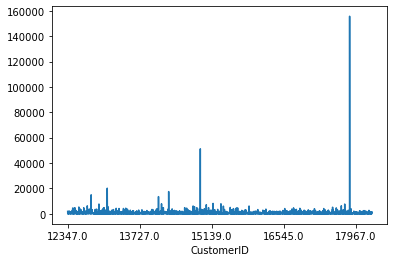

In [384]:
customers['I'].plot()

In [385]:
customers[customers.I>60000]

,I,Iu,Imax,TotalSpent,ShopSessions,Country,Day,Month
CustomerID,,,,,,,,
17841.00,155680,3086,1727,171934.46,60660,['United Kingdom'],Tuesday,November


In [386]:
df[df.CustomerID == 17841.00]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
1441,C536543,2010-01-12 14:30:00,2.10,17841.00,United Kingdom,22632,HAND WARMER RED RETROSPOT,-1
1442,C536543,2010-01-12 14:30:00,0.85,17841.00,United Kingdom,22355,CHARLOTTE BAG SUKI DESIGN,-2
1444,536544,2010-01-12 14:32:00,2.51,17841.00,United Kingdom,21774,DECORATIVE CATS BATHROOM BOTTLE,2
1446,536544,2010-01-12 14:32:00,1.66,17841.00,United Kingdom,21787,RAIN PONCHO RETROSPOT,2
1447,536544,2010-01-12 14:32:00,1.66,17841.00,United Kingdom,21790,VINTAGE SNAP CARDS,9
...,...,...,...,...,...,...,...,...
541519,581498,2011-09-12 10:26:00,4.13,17841.00,United Kingdom,82600,N0 SINGING METAL SIGN,4
541521,581498,2011-09-12 10:26:00,5.79,17841.00,United Kingdom,84032A,CHARLIE+LOLA PINK HOT WATER BOTTLE,4
541532,581498,2011-09-12 10:26:00,4.13,17841.00,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,1
541534,581498,2011-09-12 10:26:00,3.29,17841.00,United Kingdom,85049a,TRADITIONAL CHRISTMAS RIBBONS,5


In [387]:
customers = customers.drop([17841.00])

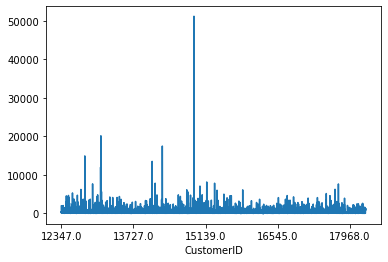

In [388]:
customers.I.plot()

**E' UN ALTRO OUTLIER ???**

## Density plots 

We now check the distribution of these new indicators, using the **density plot**.

The density plot visualises the distribution of data over a continuous interval: the peaks helps display where values are concentrated over the interval. An advantage density plots have over histograms is that they're better at determining the distribution shape.

Text(0.5, 1.0, 'Density distribution of shoping sessions: ')

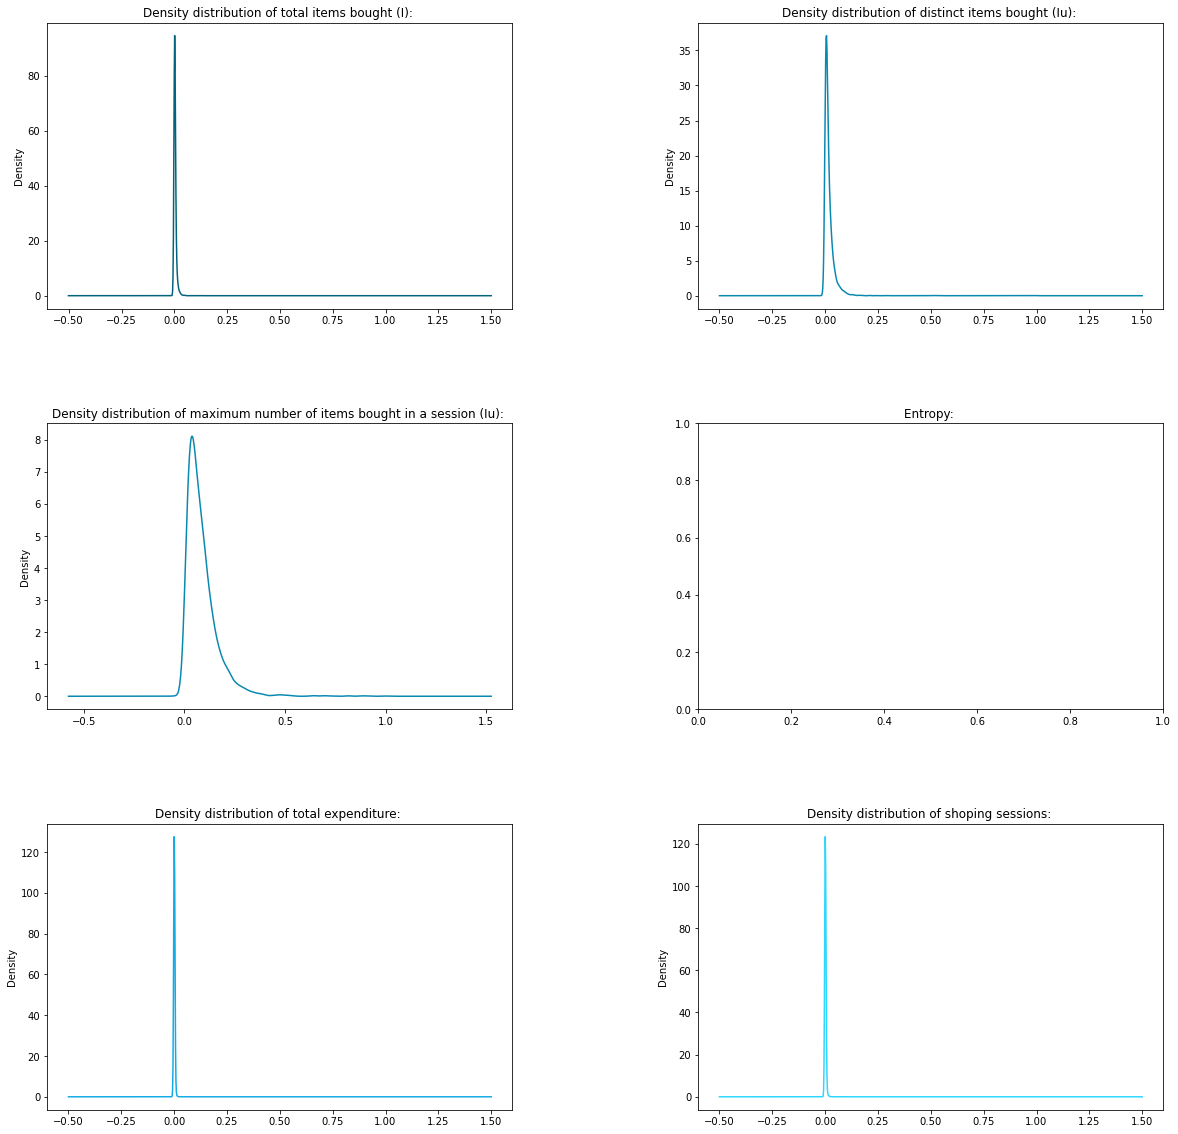

In [389]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 20))
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# I indicator
plt.subplot2grid(fig_dims, (0, 0))
customers_scaled.I.plot.kde(color="#03637B")
plt.title('Density distribution of total items bought (I): ')

# Iu indicator 
plt.subplot2grid(fig_dims, (0, 1))
customers_scaled.Iu.plot.kde(color="#0988B0") 
plt.title('Density distribution of distinct items bought (Iu): ') 

# Imax indicator
plt.subplot2grid(fig_dims, (1, 0))
customers_scaled.Imax.plot.kde(color="#0988B0") 
plt.title('Density distribution of maximum number of items bought in a session (Iu): ') 

# E indicator
plt.subplot2grid(fig_dims, (1, 1))
plt.title('Entropy: ')


# Sales per customer
plt.subplot2grid(fig_dims, (2, 0))
customers_scaled.TotalSpent.plot.kde(color="#14ABE5")
plt.title('Density distribution of total expenditure: ')

# Shopping sessions per customer
plt.subplot2grid(fig_dims, (2, 1))
customers_scaled.ShopSessions.plot.kde(color="#2ED7FF")
plt.title('Density distribution of shoping sessions: ')

*Osservazioni sul tipo di distribuzione*

## Frequencies

...

Smaller number of bins can make the plot cluttered, but a larger number may obscure nuances in the data. So we choose a reasonable number for our purpose, depending on the data that we are going to visualize.

(0.0, 1500.0, 0.0, 800.0)

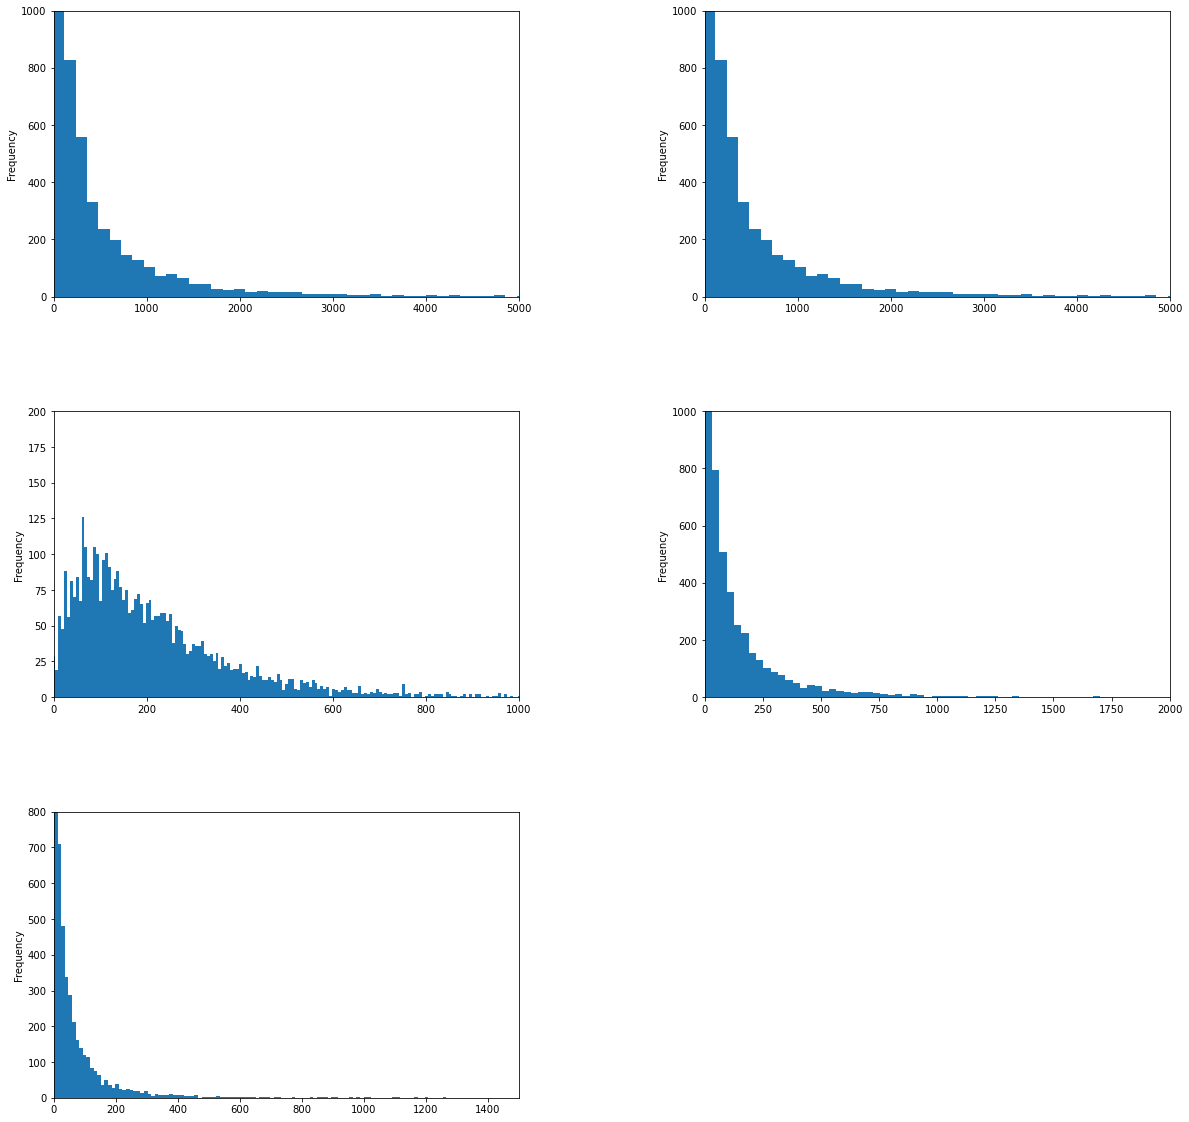

In [390]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 20))
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# set number of bins
bins = (df.CustomerID.unique().size -1) / 10 # 'size-1' because we dropped the UK record from the customers list
bins = round(bins)

# I indicator
plt.subplot2grid(fig_dims, (0, 0))
customers.I.plot(kind='hist', bins=bins)
plt.axis([0,5000,0,1000])

# Iu indicator
plt.subplot2grid(fig_dims, (0, 1))
customers.I.plot(kind='hist', bins=bins)
plt.axis([0,5000,0,1000])

# Imax
plt.subplot2grid(fig_dims, (1, 0))
customers.Imax.plot(kind='hist', bins=bins)
plt.axis([0,1000,0,200])

# Sales per customer
plt.subplot2grid(fig_dims, (1, 1))
customers.TotalSpent.plot(kind='hist', bins=bins)
plt.axis([0,2000,0,1000])

# Shopping sessions per customer
plt.subplot2grid(fig_dims, (2, 0))
customers.ShopSessions.plot(kind='hist', bins=bins)
plt.axis([0,1500,0,800])

**Aggiungere descrizione**

ESEMPIO:

What appears from the frequency plot of this new indicator is that more people are spending very little, while just few customers spend more.

## Correlations

In [391]:
customers.corr()

,I,Iu,Imax,TotalSpent,ShopSessions
I,1.00,0.77,0.54,0.80,0.82
Iu,0.77,1.00,0.58,0.85,0.91
Imax,0.54,0.58,1.00,0.40,0.43
TotalSpent,0.80,0.85,0.40,1.00,0.98
ShopSessions,0.82,0.91,0.43,0.98,1.00


In [392]:
customers.corr(method='spearman')

,I,Iu,Imax,TotalSpent,ShopSessions
I,1.00,0.86,0.88,0.84,0.88
Iu,0.86,1.00,0.75,0.96,0.99
Imax,0.88,0.75,1.00,0.67,0.74
TotalSpent,0.84,0.96,0.67,1.00,0.97
ShopSessions,0.88,0.99,0.74,0.97,1.00


In [393]:
customers.corr(method='kendall')

,I,Iu,Imax,TotalSpent,ShopSessions
I,1.00,0.68,0.72,0.65,0.72
Iu,0.68,1.00,0.56,0.83,0.93
Imax,0.72,0.56,1.00,0.48,0.55
TotalSpent,0.65,0.83,0.48,1.00,0.87
ShopSessions,0.72,0.93,0.55,0.87,1.00


### Scatter Plots

Text(0.5, 1.0, 'Correlation between max number of items bought and total expenditure/shopping sessions')

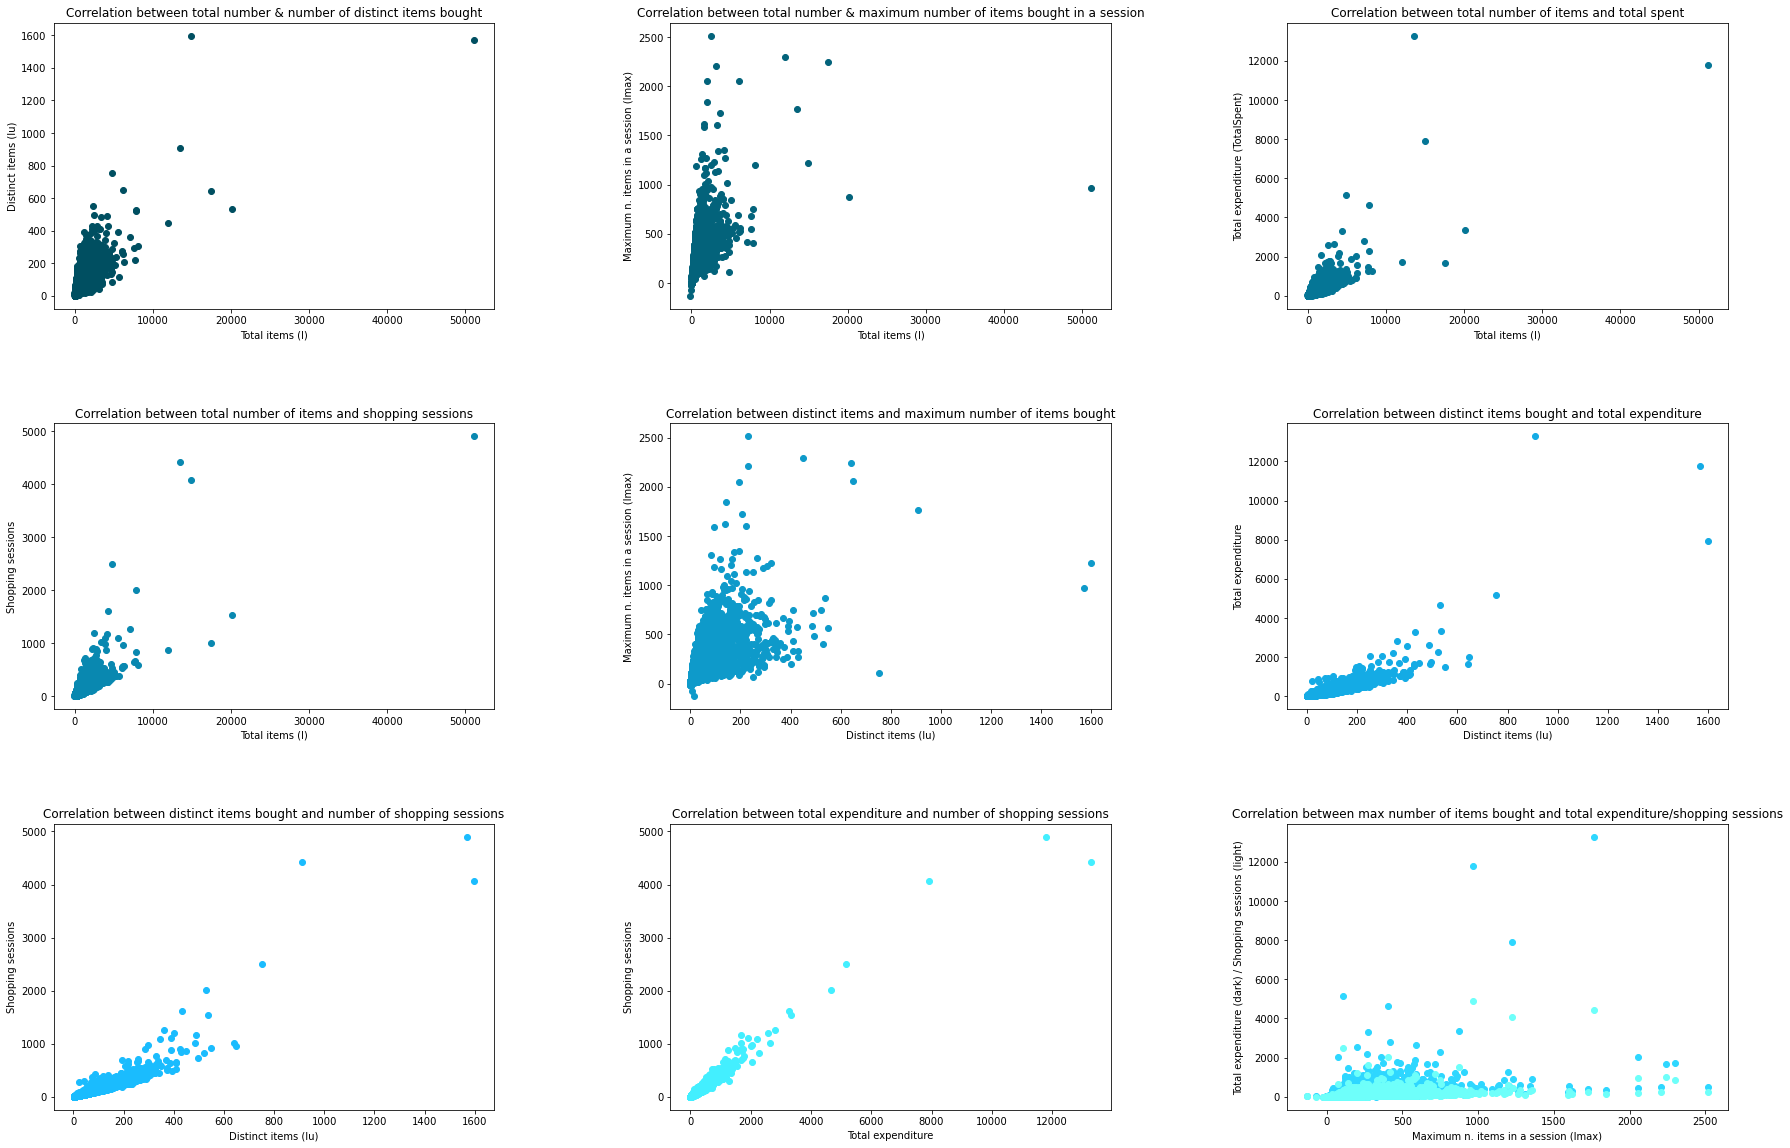

In [394]:
colors2 = ["#004F61", "#03637B", "#057696", "#0988B0", "#0E9ACA", "#14ABE5", "#1ABCFE", "#2ED7FF", "#43EFFF", "#58FFFF", "#6EFFFA", "#85FFF0", "#9CFFEA"]
colors3 = ["#805F0D", "#929210", "#81A413", "#60B617", "#38C81B", "#1FDA35", "#23EA74", "#28FAB9", "#3EFDED", "#55E7FF", "#6CCAFF", "#84B7FF", "#9CAFFF", "#BAB6FF", "#DED0FF"]

# Set up a grid of plots:
fig = plt.figure(figsize=(30, 20))
fig_dims = (3, 3)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Scatterplot between I and Iu
plt.subplot2grid(fig_dims, (0, 0))
plt.scatter(customers.I, customers.Iu, color=colors2[0])
plt.xlabel('Total items (I)')
plt.ylabel('Distinct items (Iu)')
plt.title('Correlation between total number & number of distinct items bought')

# Scatterplot between I and Imax
plt.subplot2grid(fig_dims, (0, 1))
plt.scatter(customers.I, customers.Imax, color=colors2[1])
plt.xlabel('Total items (I)')
plt.ylabel('Maximum n. items in a session (Imax)')
plt.title('Correlation between total number & maximum number of items bought in a session')

# Scatterplot between I and TotalSpent
plt.subplot2grid(fig_dims, (0, 2))
plt.scatter(customers.I, customers.TotalSpent, color=colors2[2])
plt.xlabel('Total items (I)')
plt.ylabel('Total expenditure (TotalSpent)')
plt.title('Correlation between total number of items and total spent')


# Scatterplot between I ans ShopSessions
plt.subplot2grid(fig_dims, (1, 0))
plt.scatter(customers.I, customers.ShopSessions, color=colors2[3])
plt.xlabel('Total items (I)')
plt.ylabel('Shopping sessions')
plt.title('Correlation between total number of items and shopping sessions')

# Scatterplot between Iu and Imax
plt.subplot2grid(fig_dims, (1, 1))
plt.scatter(customers.Iu, customers.Imax, color=colors2[4])
plt.xlabel('Distinct items (Iu)')
plt.ylabel('Maximum n. items in a session (Imax)')
plt.title('Correlation between distinct items and maximum number of items bought')

# Scatterplot between Iu and TotalSpent
plt.subplot2grid(fig_dims, (1, 2))
plt.scatter(customers.Iu, customers.TotalSpent, color=colors2[5])
plt.xlabel('Distinct items (Iu)')
plt.ylabel('Total expenditure')
plt.title('Correlation between distinct items bought and total expenditure')

# Scatterplot between Iu and ShopSessions
plt.subplot2grid(fig_dims, (2, 0))
plt.scatter(customers.Iu, customers.ShopSessions, color=colors2[6])
plt.xlabel('Distinct items (Iu)')
plt.ylabel('Shopping sessions')
plt.title('Correlation between distinct items bought and number of shopping sessions')

# Scatterplot between 
plt.subplot2grid(fig_dims, (2, 1))
plt.scatter(customers.TotalSpent, customers.ShopSessions, color=colors2[8])
plt.xlabel('Total expenditure')
plt.ylabel('Shopping sessions')
plt.title('Correlation between total expenditure and number of shopping sessions')


# Scatterplot between 
plt.subplot2grid(fig_dims, (2, 2))

plt.scatter(customers.Imax, customers.TotalSpent, color=colors2[7])

plt.scatter(customers.Imax, customers.ShopSessions, color=colors2[10])
plt.xlabel('Maximum n. items in a session (Imax)')
plt.ylabel('Total expenditure (dark) / Shopping sessions (light)')
plt.title('Correlation between max number of items bought and total expenditure/shopping sessions')

**OSSERVAZIONI SU SCATTER PLOTS**

## Customers purchase behavior in each country (DA SISTEMARE)
**IS SUM CORRECT?**

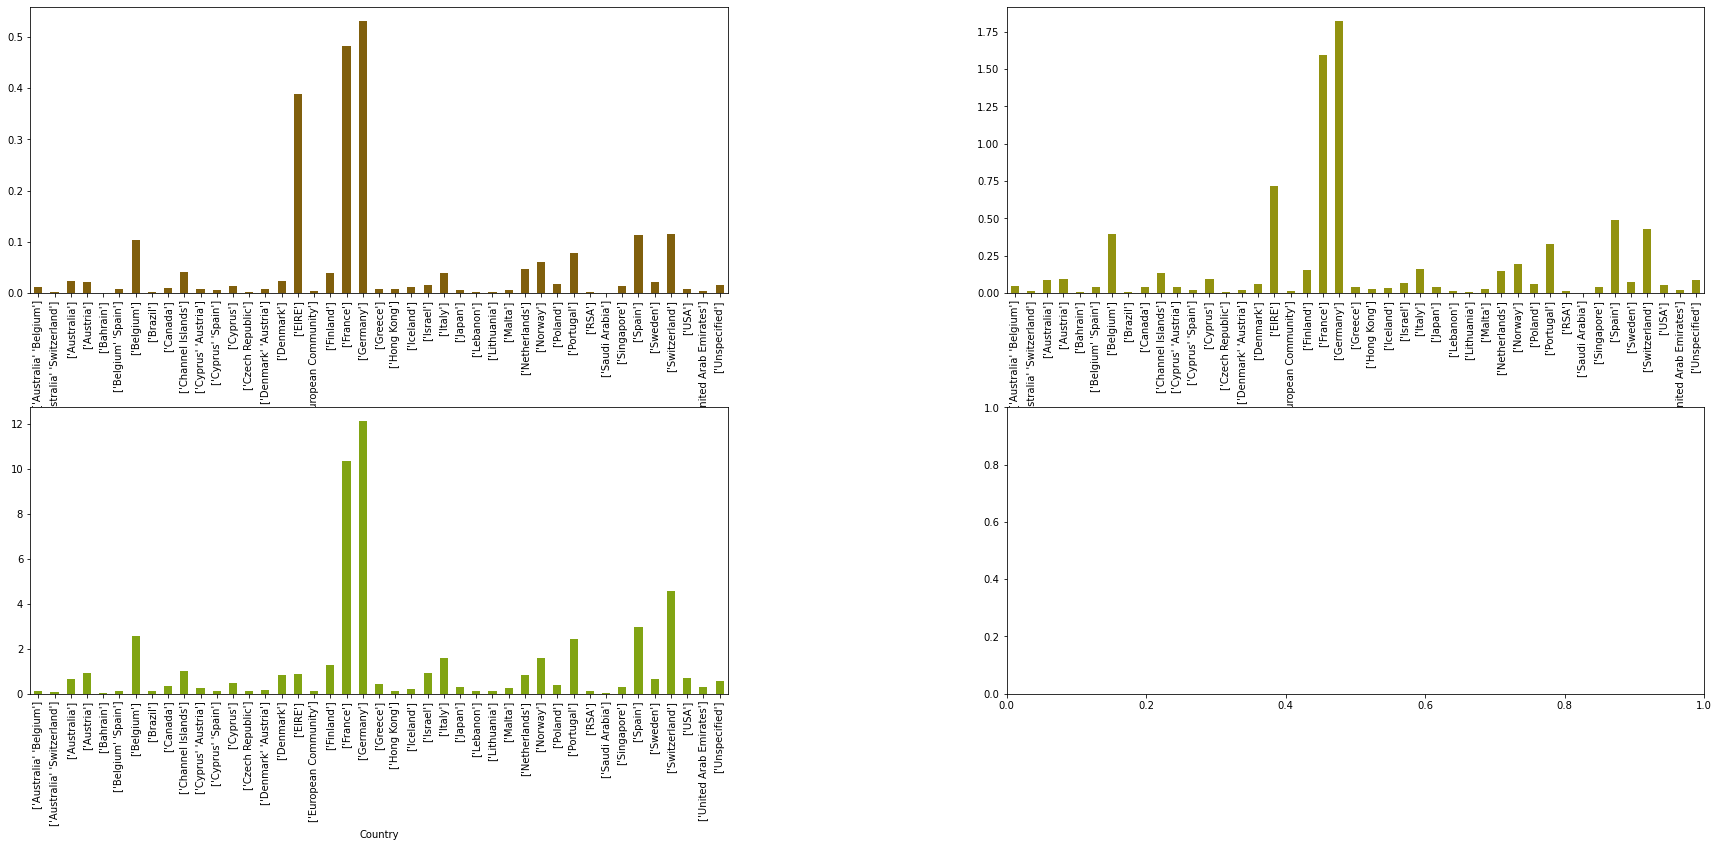

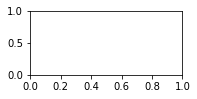

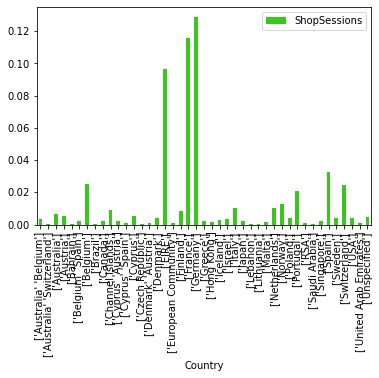

In [410]:
# Set up a grid of plots:
fig = plt.figure(figsize=(30, 20))
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# I
plt.subplot2grid(fig_dims, (0, 0))
Iscaled = pd.DataFrame(customers_scaled.I.groupby(customers.Country).sum())
Iscaled = Iscaled.drop("['United Kingdom']")
Iscaled.I.plot(kind='bar', color=colors3[0])

# Iu
plt.subplot2grid(fig_dims, (0, 1))
Iuscaled = pd.DataFrame(customers_scaled.Iu.groupby(customers.Country).sum())
Iuscaled = Iuscaled.drop("['United Kingdom']")
Iuscaled.Iu.plot(kind='bar', color=colors3[1])

# Imax
plt.subplot2grid(fig_dims, (1, 0))
Imaxscaled = pd.DataFrame(customers_scaled.Imax.groupby(customers.Country).sum())
Imaxscaled = Imaxscaled.drop("['United Kingdom']")
Imaxscaled.Imax.plot(kind='bar', color=colors3[2])


# TotalSpent
plt.subplot2grid(fig_dims, (1, 1))
TotalSpentscaled = pd.DataFrame(customers_scaled.TotalSpent.groupby(customers.Country).sum())
TotalSpentscaled = TotalSpentscaled.drop("['United Kingdom']")
TotalSpentscaled.plot(kind='bar', color=colors3[3])

# ShopSess
plt.subplot2grid(fig_dims, (2, 0))
ShopSessionsscaled = pd.DataFrame(customers_scaled.ShopSessions.groupby(customers.Country).sum())
ShopSessionsscaled = ShopSessionsscaled.drop("['United Kingdom']")
ShopSessionsscaled.plot(kind='bar', color=colors3[4])


# Rankings

In [396]:
print

<function print>